# Variational Auto Encoders for Cardiac Shape Modeling

**Supervisor:** Loïc Le Folgoc

**Group:**
* Alice Valença De Lorenci
* Artur Dandolini Pescador
* Giulia Mannaioli
* Lais Isabelle Alves dos Santos

## Objectives

The goal of this project is to implement a convolutional Variational Autoencoder (VAE) in order to build a mapping between a latent space of cardiac shape and 2D segmentation masks of the left ventricle, right ventricle and myocardium. More precisely, the input of the VAE are 4-channel 2D images, each image is the segmentation mask of one cardiac MRI slice and the channels correspond to the segmentation masks of the background, left ventricle, right ventricle and myocardium. The results will be evaluated in terms of the quality of the reconstruction of the segmentation masks.

The main articles consulted during the elaboration of the project were:
1. Biffi, C., et al. (2018) Learning interpretable anatomical features through deep generative models: Application to cardiac remodeling. *International conference on medical image computing and computer-assisted intervention*, 464-471.
2. Painchaud, N., et al. (2020) Cardiac Segmentation with Strong Anatomical Guarantees. *IEEE Transactions on Medical Imaging* 39(11), 3703-3713.

The first article was the main source of inspiration for the project while the architecture chosen for the VAE was based on the one presented in the second article.

This report is organized into the following sections:
- *Dataset*: Description of the dataset and the pre-processing steps.
- *VAE*: Implementation and description of the Variational Autoencoder.
- *Results*: Analysis of the quality of the reconstruction obtained with the VAE.

Furthermore, the following files accompany the project:
- *preprocessing.py*: Implementation of the methods needed to load and pre-process the dataset.
- *model.py*: Class implementing the VAE architecture.
- *model_evaluation.py*: Implementation of the methods used to evaluate the VAE.

## Dataset

The dataset used for this project is that of the [ACDC challenge](https://www.creatis.insa-lyon.fr/Challenge/acdc/databases.html). It consists in a training-validation set of 100 subjects and a test set of 50 subjects, both sets were mixed and later randomly split into train, validation and test sets. For all subjects, both cardiac MRI images and the corresponding segmentation maps are provided for end systole (ES) and end diastole (ED). The segmentation map includes the following structures (with respective labels):

0. Background
1. Right ventricle cavity (RV)
2. Myocardium (MY)
3. Left ventricle cavity (LV)

We chose to work only with end diastole (ED) images.

In the cells bellow we import the necessary packages, define the path to the folder containing the dataset and identify the path to the images contained in the folder.

In [251]:
# detect if it is running on colab
if 'google.colab' in str(get_ipython()):
  colab = True
else:
  colab = False

if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import sys
  # path = '/content/drive/MyDrive/Variational-Auto-Encoders-for-cardiac-shape-modeling/'
  # path = '/content/drive/MyDrive/Télécom/2A/IMA/IMA206/project/Variational-Auto-Encoders-for-cardiac-shape-modeling/'
  path = '/content/drive/MyDrive/2022-2A/IMA206/project/'
  sys.path.insert(0,path)

  try:
    import torchio
  except:
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !pip install torchio
else:
  path = ''

Mounted at /content/drive


In [252]:
# necessary libraries
import os
import nibabel as nib
import numpy as np
import torch
import torch.utils.data as torch_data

import preprocessing as pre
import model as m
import model_evaluation as eval

from IPython.display import Image

In [253]:
# if the .py is changed, run to reload
import importlib
importlib.reload(m)
importlib.reload(eval)
importlib.reload(pre)

<module 'preprocessing' from '/content/drive/MyDrive/2022-2A/IMA206/project/preprocessing.py'>

In [247]:
# Path to folder containing the dataset
if os.path.exists(path+'../ACDC/database'):
    dataset_path = path+'../ACDC/database'
elif os.path.exists(path+'./ACDC/database'):
    dataset_path = path+'./ACDC/database'
else:
    raise Exception('Define path to dataset')

testing_folder = os.path.join(dataset_path, 'testing')
training_folder = os.path.join(dataset_path, 'training')

# Identify number of patients
# The folder should not contain any file or subdirectory other than the patient's subdirectories!
nb_training = len(os.listdir(training_folder))
nb_testing = len(os.listdir(testing_folder))

# Extracting training images paths
images_train_ED_path, masks_train_ED_path, _, _ = pre.preprocess_files_acdc(training_folder, nb_training)

# Extracting testing images paths
images_test_ED_path, masks_test_ED_path, _, _ = pre.preprocess_files_acdc(testing_folder, nb_testing, test=True)

print('------------- Training dataset ------------')
print('Number of ED MRI images:\t\t{}'.format(len(images_train_ED_path)))
print('Number of ED segmentation masks:\t{}'.format(len(masks_train_ED_path)))

print('\n------------- Testing dataset  ------------')
print('Number of ED MRI images:\t\t{}'.format(len(images_test_ED_path)))
print('Number of ED segmentation masks:\t{}'.format(len(masks_test_ED_path)))

------------- Training dataset ------------
Number of ED MRI images:		100
Number of ED segmentation masks:	100

------------- Testing dataset  ------------
Number of ED MRI images:		50
Number of ED segmentation masks:	50


With the dataset in hands, first of all it is necessary to pre-process the data in order to obtain the desired input representation for the VAE, i.e., 4-channel 2D images where each image is the segmentation mask of one cardiac MRI slice and where the channels correspond to the segmentation masks of the background, LV, RV and MY. In order to describe and illustrate the pre-processing steps, they will be applied to one example image from the training dataset.

As can be seen in the cell bellow, the dataset consists in 3D MRI images and corresponding segmentation maps.

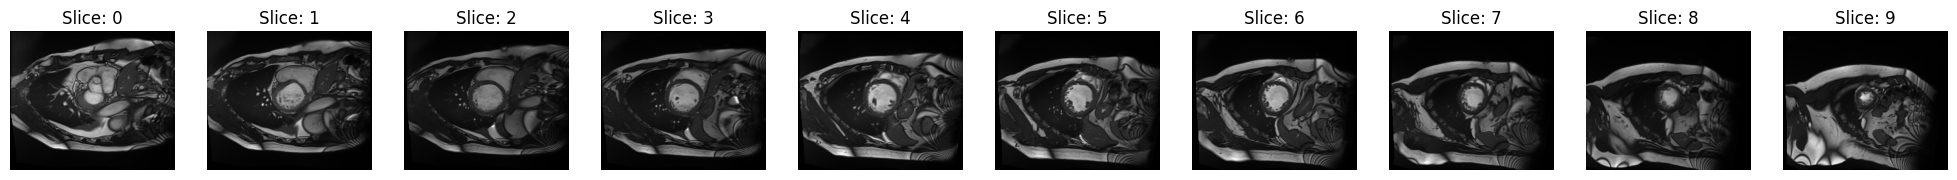

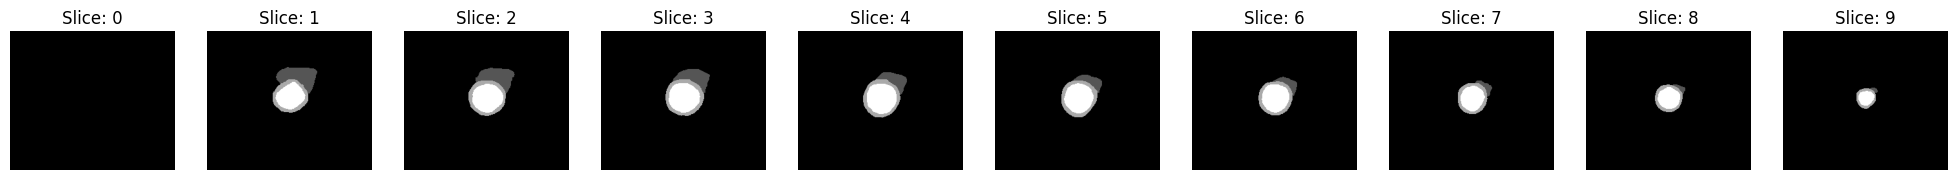

In [5]:
# Show images and masks
patient = 0
example_image = pre.heart_mask_loader( [ images_train_ED_path[patient] ] )
example_mask = pre.heart_mask_loader( [ masks_train_ED_path[patient] ] )
pre.visualize_image_mask(*example_image, *example_mask, example_image[0].shape[2])

Comparing the data of different patients, it can be observed that the relative position of the left and right ventricles varies. Therefore, in order to remove this source of variability, the 3D segmentation masks are rotated so that those structures are horizontally aligned, with the LV on the left and the RV on the right. This is done by the method ```align_heart_mask``` implemented on *preprocessing.py*. Essentially a line between the center of those two heart strutures is identified and its angle with the horizontal axis is computed, the image is then rotated by the negative of that value.

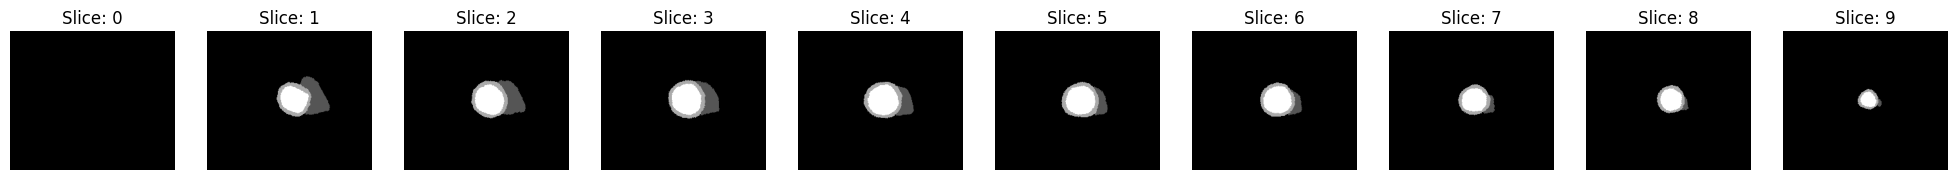

In [6]:
# Rotate masks so that the relative position of the LV and RV is always the same
example_mask = pre.align_heart_mask( example_mask )
pre.visualize_mask( *example_mask )

Also, the MRI scans include structures other than the LV, RV and MY, resulting in a large useless background area in the segmentation masks. Therefore the 3D segmentation masks are cropped to the smallest square containing the heart structures of interest, this is done by the method ```crop_heart_mask``` implemented on *preprocessing.py*.

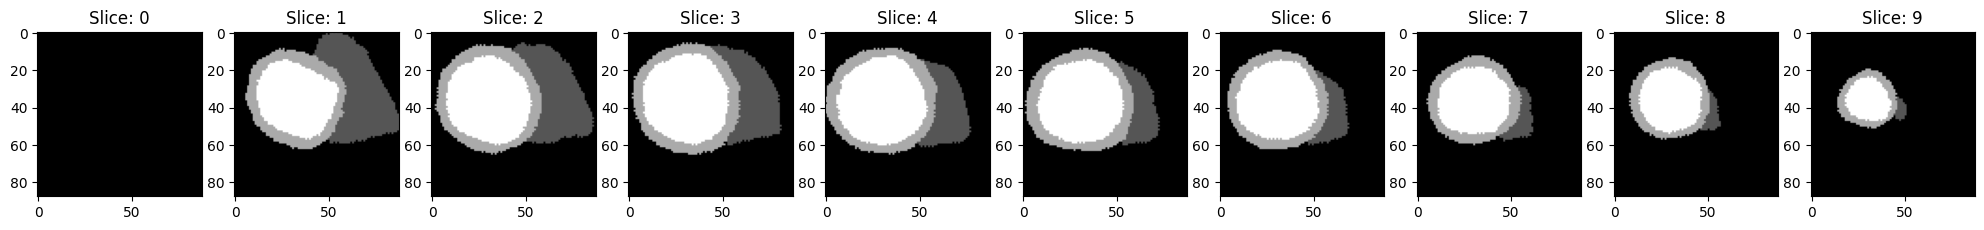

In [7]:
# Crops masks
example_mask = pre.crop_heart_mask( example_mask )
pre.visualize_mask( *example_mask, show_axis=True )

However, the cropping process results in segmentation masks of different sizes and the size of the input images of the VAE must be standardized. To solve this issue, the segmentation masks are either downsampled or upsampled using the nearest neighbour interpolation method so that each frame is of size $128 \times 128$, this is done by the method ```resize_heart_mask``` implemented on *preprocessing.py*.

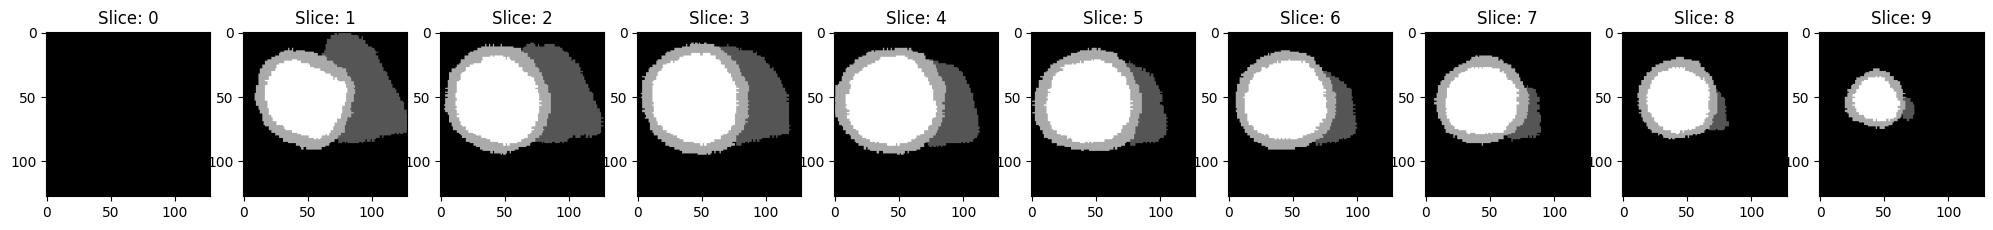

In [8]:
# Standardize image size (inputs of the network must be of same size)
example_mask = pre.resize_heart_mask( example_mask )
pre.visualize_mask( *example_mask, show_axis=True )

Before transforming the 3D masks into independent 2D masks, all slices were labeled from $0$ to $1$, with fractional values for the slices in between, in order to able to use the slice position information later on. This is done by the method ```label_slices``` implemented on *preprocessing.py*, an example is shown below.

In [10]:
# Give a label for the each slice
masks_labels = pre.label_slices( example_mask )

print('Labeling the slices of patient {}:\n{}'.format(patient, masks_labels))

Labeling the slices of patient 0:
[[0, 0.0], [0, 0.1], [0, 0.2], [0, 0.3], [0, 0.4], [0, 0.6], [0, 0.7], [0, 0.8], [0, 0.9], [0, 1.0]]


Once the 3D segmentation masks are aligned and cropped and their sizes standardized, their frames are decoupled (this is done by the method ```convert_3D_to_2D``` implemented on *preprocessing.py*.) and treated as independent 2D images.

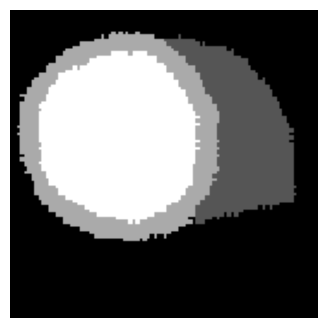

In [11]:
# Separate the frames, each frame will treated as a 2D image
example_mask = pre.convert_3D_to_2D(example_mask)

idx = 3
pre.visualize_2d_mask(example_mask[idx])

Up to this point, we have 2D segmentation masks with labels 0, 1, 2 and 3 corresponding to the background, RV, MY and LV, respectively. However we would like to have a one-hot encoding of the segmentation mask, i.e., one binary mask per channel. This transformation of the encoding is done by the method ```heart_mask_extraction``` inplemented on *preprocessing.py*.

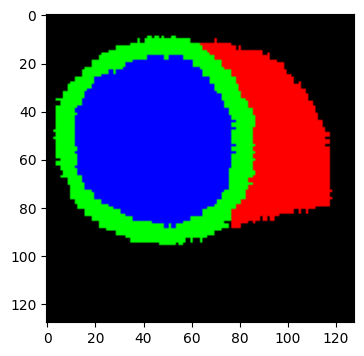

In [12]:
# Translate multilabel mask into multi channel mask (each channel represents a different structure),
# the axis are ordered according to PyTorch standard: (channel, height, width)
example_mask = pre.heart_mask_extraction(example_mask)
pre.visualize_multichannel_mask( example_mask[idx] )

All those pre-processing steps are combined on the method ```preprocessingPipeline```, implemented on *preprocessing.py*, that allows their efficient application to the entirety of the dataset. The resulting arrays are passed to a PyTorch DataLoader in order to be used to train and test the VAE.

In [14]:
data, masks_labels = pre.preprocessingPipeline(masks_train_ED_path + masks_test_ED_path)

In [15]:
# Saving the pre-processed dataset
pre.saveDataset(data, path+'./', 'ED_data')
pre.saveDataset(masks_labels, path+'./', 'masks_labels')

In [218]:
# Loading the pre-processed dataset
data = pre.loadDataset(path+'./', 'ED_data')
masks_labels = pre.loadDataset(path+'./', 'masks_labels')

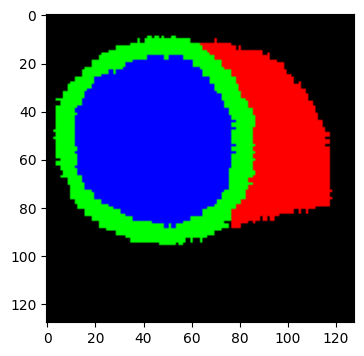

In [219]:
# Check that the data was correctly imported
test_idx = 3
pre.visualize_multichannel_mask(data[test_idx])

## VAE

A Variational Autoencoder (VAE) is a probabilistic generative model that learns to encode and decode data, allowing for the generation of new samples that resemble the training data. It consists of an encoder network, a decoder network, and a latent space representation. The architecture of the VAE is implemented in the class ```VAE``` on the file *model.py* and is inspired by that of Painchaud, N., et al. [2].

The general architecture of a VAE is illustrated in the figure bellow.

![VAE](images/image_vae.png)

Where $Z$ is the latent space representation given by:
$$Z = Z_\mu + Z_\sigma \epsilon$$
$$\epsilon \sim \mathcal{N}(0, 1)$$

The encoder network takes as input an image and transforms it into a lower-dimensional representation in the latent space. In our implementation, the encoder consists of four convolutional blocks, followed by two fully connected layers that output $Z_\mu$ and $Z_\sigma$. Each convolutional block is composed of a $2 \times 2$ convolutional layer of stride $2$ followed by a $3 \times 3$ convolutional layer of stride $1$. The number of output channels for the first layer is $48$ and it is duplicated by the first layer of each successive block. Finally, the dimensionality of the latent space was fixed at $32$. As an example, the parameters of the first block are:

1. *2D Convolutional layer*: `input = 4, output = 48, kernel_size = 2x2, stride = 2`
2. *2D Convolutional layer*: `input = 48, output = 48, kernel_size = 3x3, padding = 1`

These convolutional layers extract relevant features from the input image, while the fully connected layers map these features to the mean, $Z_\mu$, and log variance, $\log Z_\sigma^2$, of the latent space distribution, which are then used to sample a point $Z$ in the latent space.

One point to be considered during the implementation of the architecture was how to compute the input dimension of the fully connected layers. Knowing that the input of the fully connected layers is the flattened output of the convolutional layers of the encoder, to compute the necessary dimension a meta tensor is passed through the convolutional layers of the encoder and the resulting dimension can be obtained directly.  This is done using the function `compute_fc_input_dim`, implemented on *model.py*.


The decoder network takes a point $Z$ in the latent space as input and recontructs the original imagem from it. In our implementation, it mirrors the architecture of the encoder network, therefore it consists in a fully connected layer followed by four convolutional blocks. Each convolutional block is composed of a $2 \times 2$ transpose convolutional layer of stride $2$ followed by a $3 \times 3$ transpose convolutional layer of stride $1$. The number of output channels is halved by the second layer of each convolutional block and reaches $48$ before the last block. The final convolutional layer has softmax activation, giving, for each pixel, the probability of belonging to each channel.


The VAR is trained to minimize the sum of the recontruction error between the original image (encoder input) and the recontructed image (decoder output) and the KL divergence between the imposed Gaussian prior distribution and the approximate a posteriori distribution.

To measure the reconstruction error, we use the *Soft Dice Loss*, which is the measure of the overlap between two samples, the predicted and the ground truth masks. The Soft Dice Loss is defined as:

$$L_{Dice} = 1 - \frac{2 \sum_{i=1}^{N} p_i g_i + \epsilon}{\sum_{i=1}^{N} p_i^2 + \sum_{i=1}^{N} g_i^2 + \epsilon}$$

Where $p_i$ and $g_i$ are the predicted and ground truth values, respectively, and $\epsilon$ is a small constant to avoid division by zero.

Additionally, the *Kullback-Leibler Divergence (KLD) Loss* is used to encourage the latent space distribution to resemble a Gaussian distribution. The KLD loss is defined as:

$$L_{KLD} = -\frac{1}{2} \sum_{i=1}^{N} (1 + log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$$

Where $\mu_i$ and $\sigma_i$ are the mean and standard deviation of the latent space distribution, respectively, and $N$ is the number of dimensions of the latent space.

For the model, the following values are used in order to obtain good results.

- `batch_size = 64`: number of samples evaluated in each training iteration
- `z_dim = 32`: dimension of the latent space
- `lamb = 1e-5`: trade off hyperparameter for the KLD to generate different samples
- `learning_rate = 6e-5`: learning rate of the Adam optimizer, with suggestion from the paper [2]
- `l2 = 0.01`: regularization parameter for the Adam optimizer

In [220]:
# Decide in which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"

print("Running on", device)

Running on cuda:0


In [221]:
batch_size = 64

# Create datasets that contain tensors for features and labels
tensor_dataset = torch_data.TensorDataset(torch.Tensor(data), torch.Tensor(masks_labels))

# Define train, validation and test sets
train_set, val_set, test_set = torch_data.random_split(tensor_dataset, [0.6, 0.2, 0.2])

# Separate the labels and the data
train_data, train_labels = train_set[:]
val_data, val_labels = val_set[:]
test_data, test_labels = test_set[:]

# Define the data loaders
train_loader = torch_data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch_data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch_data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [222]:
# Define the dimensions of the input space
n_channels = 4
n_rows = n_cols = train_data[0].shape[-1]
z_dim = 32

# Reconstruction error vs. KLD trade-off hyperparameter
lamb = 1e-5

# Create an instance of the VAE model
model = m.VAE(n_rows, n_cols, n_channels, z_dim, lamb).to(device)

In [223]:
# Define the optimizer
learning_rate = 6e-5
l2 = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)

In [224]:
num_epochs = 100
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    new_train_loss, new_val_loss = model.train_one_epoch(optimizer, train_loader, val_loader, epoch=epoch, device=device)
    train_loss.append(new_train_loss)
    val_loss.append(new_val_loss)

Epoch: 0	Average train loss: 0.8066
		Average validation loss: 0.8040
Epoch: 1	Average train loss: 0.8030
		Average validation loss: 0.7996
Epoch: 2	Average train loss: 0.7961
		Average validation loss: 0.7906
Epoch: 3	Average train loss: 0.7778
		Average validation loss: 0.7704
Epoch: 4	Average train loss: 0.7703
		Average validation loss: 0.7669
Epoch: 5	Average train loss: 0.7658
		Average validation loss: 0.7614
Epoch: 6	Average train loss: 0.7438
		Average validation loss: 0.6851
Epoch: 7	Average train loss: 0.6265
		Average validation loss: 0.5878
Epoch: 8	Average train loss: 0.5728
		Average validation loss: 0.5598
Epoch: 9	Average train loss: 0.5469
		Average validation loss: 0.5315
Epoch: 10	Average train loss: 0.5205
		Average validation loss: 0.5089
Epoch: 11	Average train loss: 0.4969
		Average validation loss: 0.4947
Epoch: 12	Average train loss: 0.4776
		Average validation loss: 0.4588
Epoch: 13	Average train loss: 0.4388
		Average validation loss: 0.4115
Epoch: 14	Averag

In [225]:
# Save model so that we don't have to retrain every time
torch.save(model.state_dict(), path+'./model_{}.pt'.format(str(lamb)))

In [226]:
# Load saved model
model = m.VAE(n_rows, n_cols, n_channels, z_dim).to(device)
model.load_state_dict(torch.load(path+'./model_{}.pt'.format(str(lamb)), map_location=device))

<All keys matched successfully>

To assess the model's performance, the train and validation losses were plotted below on the same graph.

Total epochs:  100


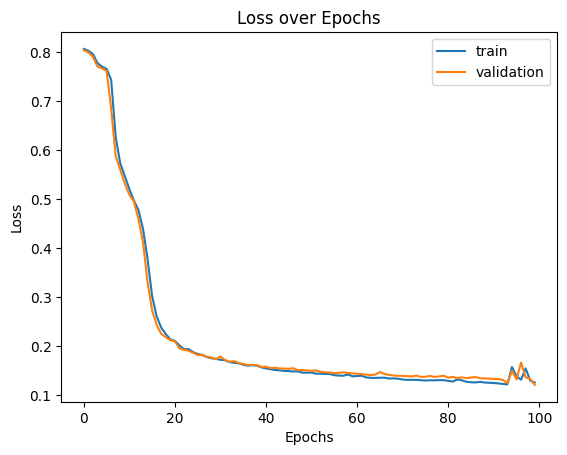

Test loss:  3.7591371375703653


In [227]:
# Plot train and validation losses...
eval.plot_loss(train_loss, val_loss)
# ... and evalutate test loss
test_loss = model.compute_test_loss(test_loader, device)
print( "Test loss: ", test_loss )
# save all losses
eval.save_loss(train_loss, val_loss, test_loss, path, str(lamb))

It is possible to observe that both losses decrease over time and both are very cose to each other, which indicates that the model learned to generalize well and that it is able to reconstruct the images from the latent space.

## Results

### Reconstruction

In this section we present the results obtained with the Variational Autoencoder implemented in the previous section. The VAE was trained for 100 epochs with a batch size of 64 and a learning rate of $6\cdot 10^{-5}$. The KLD is combined with the Soft Dice loss to generate the overall loss function of the model. This is done in the function `loss_function` in *model.py*.

Below, we present the original segmentation masks and the corresponding recontruction obtained with the trained model for some test samples.

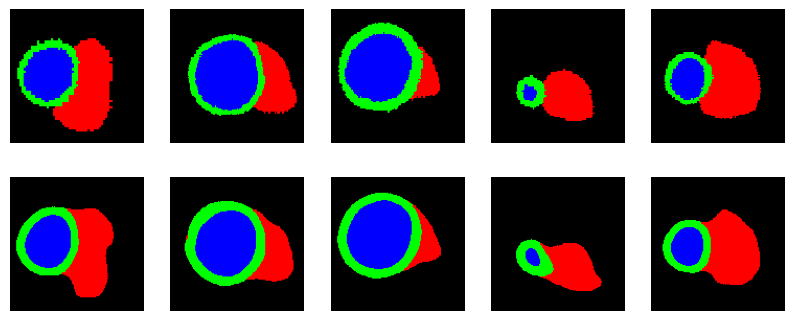

In [206]:
# Visualize test set reconstruction
data = next(iter(test_loader))[:5]
eval.visualize(model, data, device=device)

To better understand and quality the reconstructions obtained with the VAE, we present below the best and worst reconstructions obtained with the trained model. The following function `sorted_recon_losses`, present in *model_evaluation.py*, evaluates the quality of the resconstructed images compared to the original images with the Soft Dice Loss and returns the indices of the best and worst images.

In [ ]:
recon_losses, original_images, reconstructed_images, indices = eval.sorted_recon_losses(model, test_loader, device)

Below we present the **best recontructions** obtained with the trained model that showcase the ability to accurately reconstruct the segmentation masks. The model was able to preserve the main characteristics of the cardiac structures, such as the ventricles and the myocardium.

Best Recontructions:


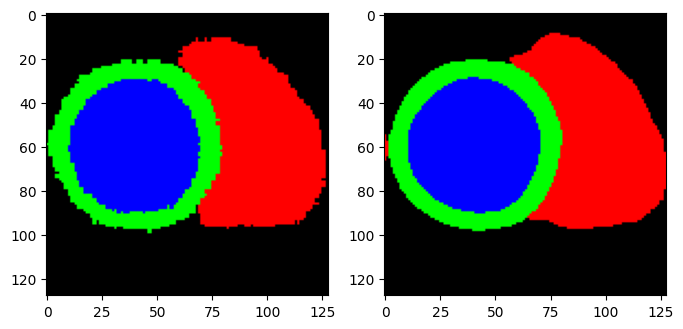

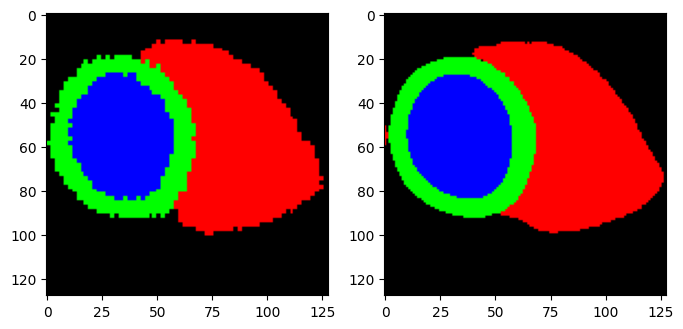

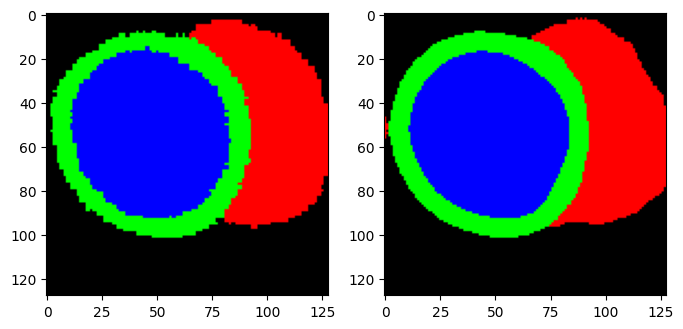

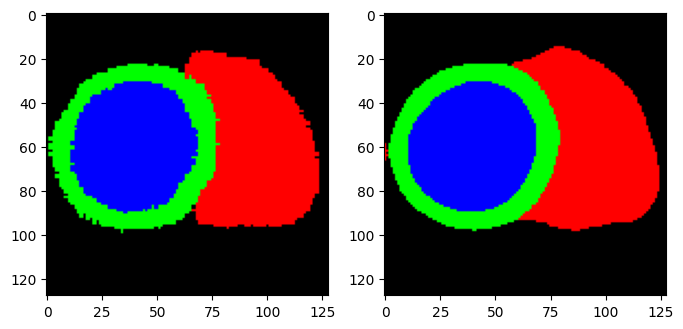

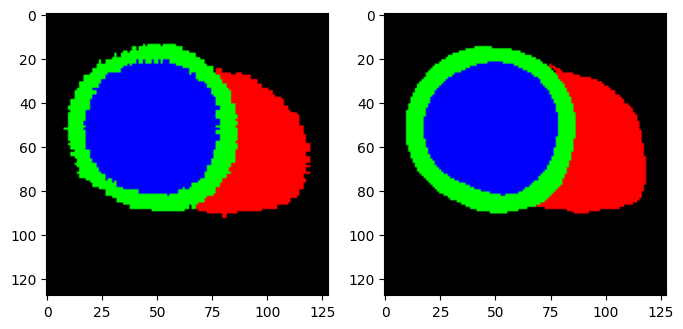

In [ ]:
# Visualize test set reconstruction (ordered by reconstruction loss)
# Best recontruction
print("Best Recontructions:")
data_best = original_images[indices[:5]]
eval.visualize(model, data_best, device=device)

The worst recontructions are exhibit below. As it is possible to see, the model was not able to reproduce with a high accuracy the original image, specifically in these cases where the original image is all black (background).

Worst Recontructions:


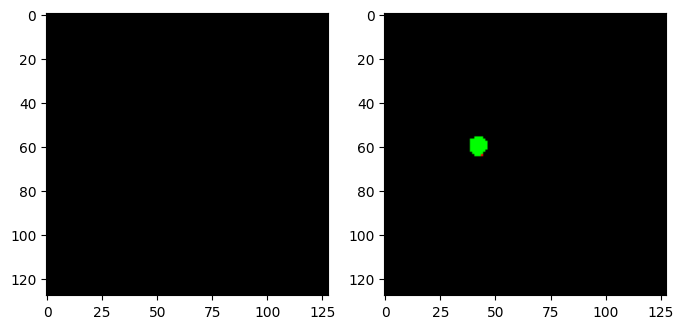

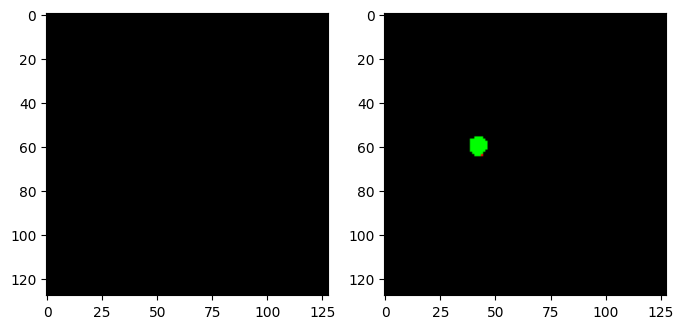

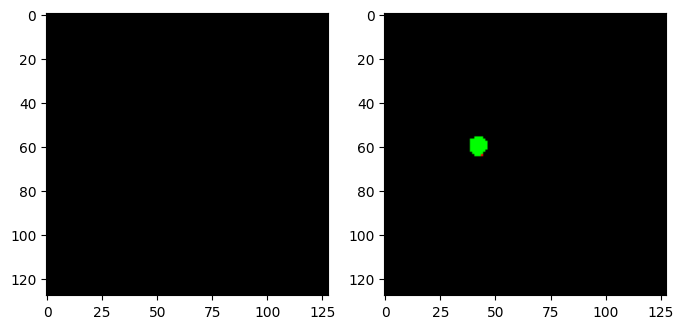

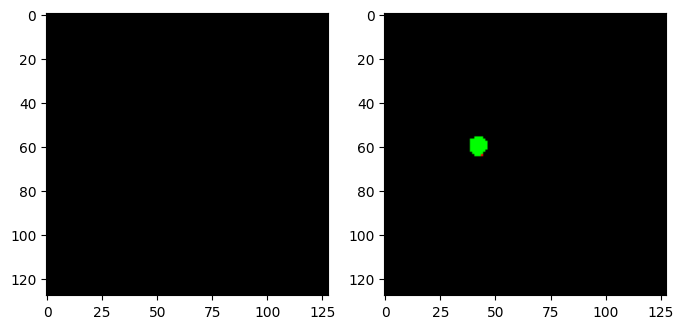

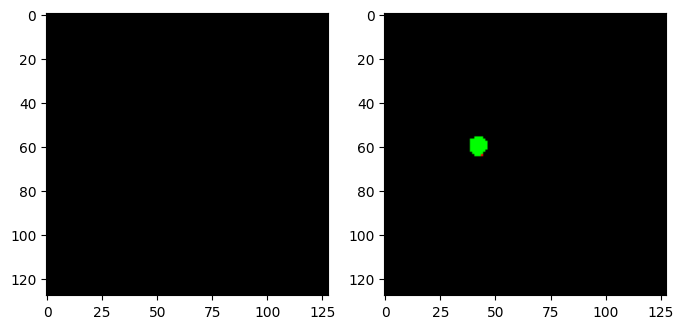

In [ ]:
print ("Worst Recontructions:")
data_worst = original_images[indices[-5:]]
eval.visualize(model, data_worst, device=device)

### Data generation and latent space analysis

Other than the reconstruction quality, the VAE must also be analised as a generative model. The loss that is being minimized during training is:
$$\mathcal L = \frac{1}{n} \sum_{i=1}^{n}\operatorname{DiceLoss}(x^{(i)}, \hat x^{(i)}) + \lambda \frac{1}{2} \sum_{j=1}^{d} \left( {Z_\mu}_j^2 + {Z_\sigma}_j^2 - 1 - \log {Z_\sigma}_j^2\right)$$
where the second term is the KL divergence term and $d$ is the size of the latent space. Furthermore, $\lambda$ is a trade-off parameter that controls the influence of each term in the loss.

In order to obtain good reconstruction results, it was necessary to set a small value for $\lambda$ ($\lambda = 10^{-5}$). However, a VAE can be used as a generative model due to the probabilistic modelling of the latent space through the KL divergence term in the loss function. For such a low weight of the KL divergence term we did not expect the trained model to generate realistic masks when sampling the latent space from a Gaussian distribution. Indeed, doing so and displaying the generated images in the cell bellow, it can be seen that the output does not resemble heart segmentation masks.



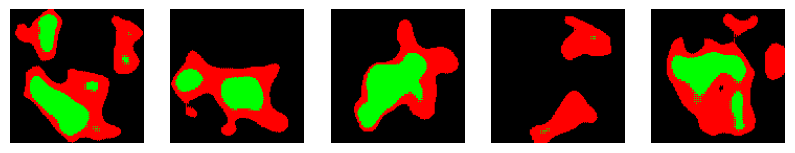

In [254]:
lamb = 1e-5

# Load saved model
model = m.VAE(n_rows, n_cols, n_channels, z_dim).to(device)
model.load_state_dict(torch.load(path+'./model_{}.pt'.format(str(lamb)), map_location=device))

# Generate new images
_, generated_images = model.generate_images(5, device)
eval.visualize_generated_images(generated_images)

In view of the bad quality of the generated images, we trained the VAE for different values of $\lambda$ and compared the reconstruction and generation results.

![VAE](images/generated_lamb0.1.png)
![VAE](images/generated_lamb0.01.png)
![VAE](images/generated_lamb0.001.png)
![VAE](images/generated_lamb0.0001.png)
![VAE](images/generated_lamb1e-05.png)

In [ ]:
# lambda_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
# eval.evaluate_lambda(train_loader, val_loader, test_loader, lambda_list, device, path)

In [ ]:
lamb = 1

In [ ]:
# Load saved model
model = m.VAE(n_rows, n_cols, n_channels, z_dim).to(device)
model.load_state_dict(torch.load(path+'./model_{}.pt'.format(lamb), map_location=device))

<All keys matched successfully>

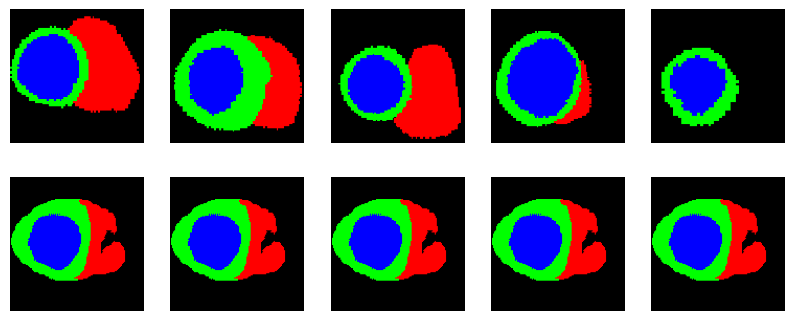

In [ ]:
# Visualize test set reconstruction
data = next(iter(test_loader))[:5]
eval.visualize(model, data, device=device, save=True, path=path)

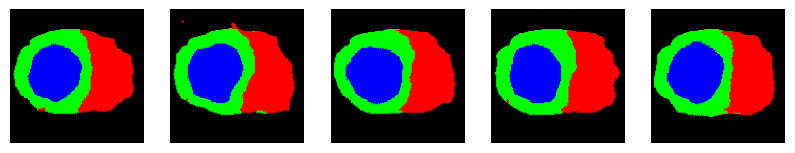

In [ ]:
# Generate new images
_, generated_images = model.generate_images(5, device)
eval.visualize_generated_images(generated_images, save=True, path=path, lamb=lamb)

Total epochs:  100


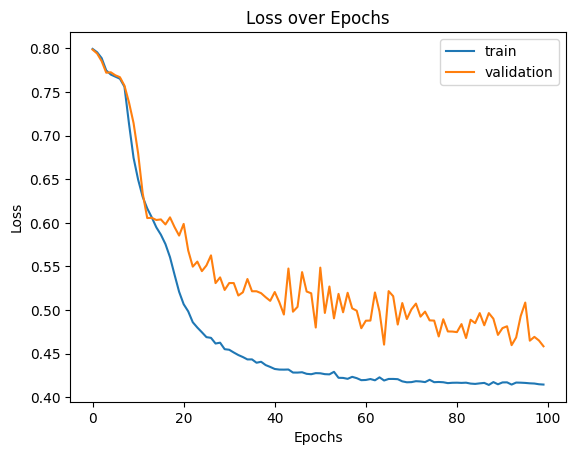

Test loss:  0.4576039298214896


In [ ]:
train_loss, val_loss, test_loss = eval.load_loss(path, str(lamb))
# Plot train and validation losses...
eval.plot_loss(train_loss, val_loss)
# ... and evalutate test loss
test_loss = model.compute_test_loss(test_loader, device)
print( "Test loss: ", test_loss )

### Evaluate average error

In [ ]:
def retrieve_2D_labeled_images(model, input_tensor, labels_tensor, device):
    """
    Retrieve images according to their corresponding labels

    Parameters:
    -----------
    `model`: VAE object, the trained VAE model
    `input_tensor` : tensor, input images
    `labels_tensor`: tensor, patient identification and labels
    `device` : torch.device, the device to use for predicting
    """
    input = input_tensor.cpu().detach().numpy()
    labels = labels_tensor.cpu().detach().numpy()
    output_tensor = model.predict(input_tensor, device)
    output = output_tensor.cpu().detach().numpy()

    lower_idxs = []
    middle_idxs = []
    upper_idxs = []

    for position, label in enumerate(labels[:,1]):
        if (label == 0.):
            lower_idxs.append(position)
        elif (label >= 0.4 and label < 0.6):
            middle_idxs.append(position)
        elif (label == 1.):
            upper_idxs.append(position)

    input_lower = input[lower_idxs]
    input_middle = input[middle_idxs]
    input_upper = input[upper_idxs]

    output_lower = output[lower_idxs]
    output_middle = output[middle_idxs]
    output_upper = output[upper_idxs]

    images = [input_lower, input_middle, input_upper, output_lower, output_middle, output_upper]

    return images

In [ ]:
def transform_tensor_list(tensor_list):
  tensor_list_transformed = []

  for tensor in tensor_list:
    tensor_list_transformed.append(tensor)

  tensor_list = torch.stack(tensor_list_transformed)
  return tensor_list

(4, 128, 128)


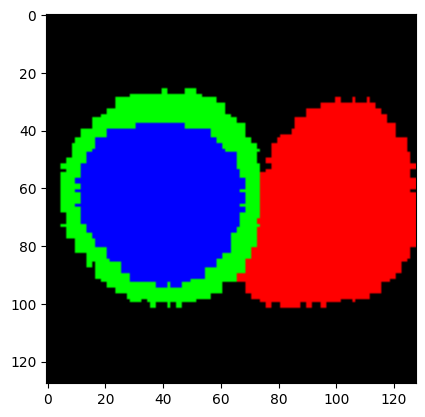

In [ ]:
import matplotlib.pyplot as plt
# Retrieve the labels from lower, middle and upper slices
data = transform_tensor_list(test_data_set)
labels = transform_tensor_list(test_labels)

ims = retrieve_2D_labeled_images(model, data, labels, device)

# Visualize images
print(ims[0][0].shape)
plt.imshow( np.moveaxis( ims[0][0], [0,1,2], [2,0,1] )[:,:,1:] )

In [ ]:
data.shape

torch.Size([64, 4, 128, 128])

In [ ]:
masks_labels_train.shape

(951, 2)

### Clustering

In [ ]:
# Let's see how the latent space is organized

# Generate mu and logvar
mus, logvars = eval.generate_latent(model, train_loader, device)

# Check if the distribution is normal
eval.check_distribution(mus, logvars)

Mu: mean=-0.12316560000181198, std=3.1378846168518066
Std: mean=0.049389734864234924, std=0.024575062096118927


Text(0, 0.5, 'Principal Component 2')

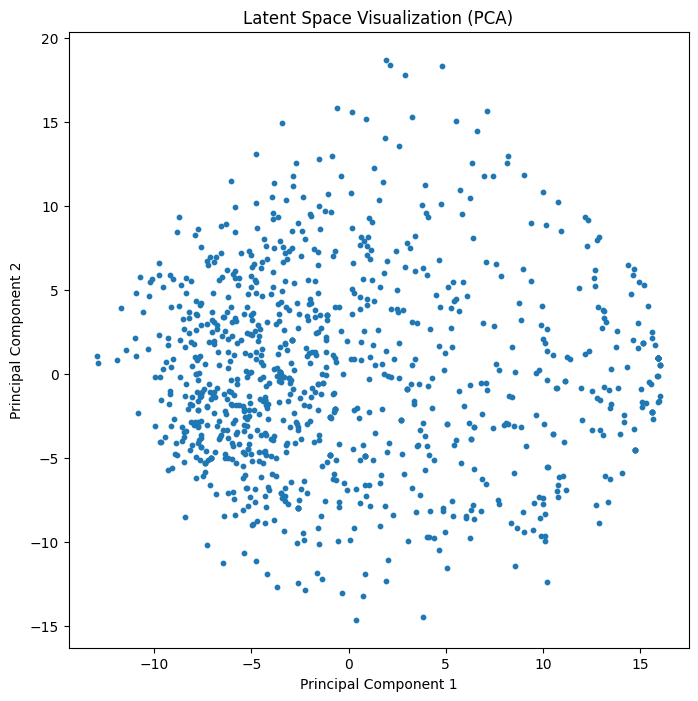

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Move latent vectors to CPU
latent_vectors_cpu = mus.cpu().numpy()

# Perform dimensionality reduction using PCA
pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(latent_vectors_cpu)

# Plot the latent space with PCA
plt.figure(figsize=(8, 8))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], s=10)
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'Principal Component 2')

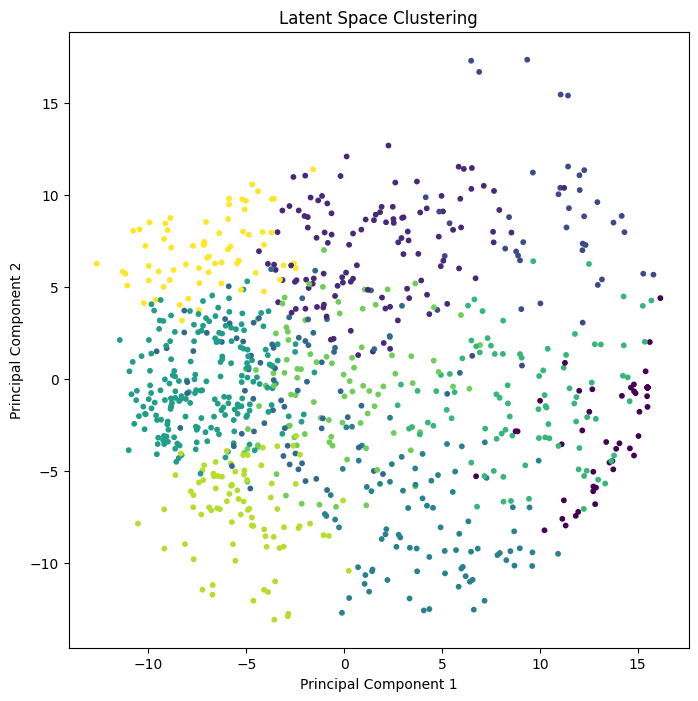

In [ ]:
# Perform clustering on the latent vectors
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(latent_vectors_cpu)

# Plot the clusters in the latent space
plt.figure(figsize=(8, 8))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.title('Latent Space Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')